In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import sys
from tqdm import tqdm
import seaborn as sns
figure = 0
import warnings
warnings.filterwarnings("ignore")

In [2]:
cifar_10_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
cifar_10_file = 'cifar-10-python.tar.gz'

from urllib.request import urlretrieve
from os.path import  isfile, isdir
from tqdm import tqdm #progress bar etc
import tarfile #ability to read and write tar files


cifar10_data_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
  last_block = 0

  def hook(self, block_num=1, block_size=1, total_size=None):
    if total_size is not None:
      self.total = total_size
      self.update(block_num * block_size - self.n)

  """
  check if the file is already existing, if not, download it from the source
  """

if not isfile(cifar_10_file):
  with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
    #retrieve a url into a temporary location on the disk
    urlretrieve(
        cifar_10_url,
        cifar_10_file,
        pbar.hook
    )

if not isdir(cifar10_data_folder_path):
  with tarfile.open(cifar_10_file) as tar:
    tar.extractall()
    tar.close()


In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def one_hot(labels, number_distinct_labels=10):
    labels_one_hot = np.zeros(shape=(number_distinct_labels,len(labels)))
    for i, label in enumerate(labels):
        labels_one_hot[label,i] = 1
    return labels_one_hot

def LoadBatch(file):
    data = unpickle(file)
    images = data[b'data'].T
    labels = data[b'labels']
    labels_one_hot = one_hot(labels) 
    return images, labels_one_hot, labels

In [4]:
images_1, labels_one_hot_1, labels_1 = LoadBatch('cifar-10-batches-py/data_batch_1')
images_2, labels_one_hot_2, labels_2 = LoadBatch('cifar-10-batches-py/data_batch_2')
images_3, labels_one_hot_3, labels_3 = LoadBatch('cifar-10-batches-py/data_batch_3')
images_4, labels_one_hot_4, labels_4 = LoadBatch('cifar-10-batches-py/data_batch_4')
images_5, labels_one_hot_5, labels_5 = LoadBatch('cifar-10-batches-py/data_batch_5')
images_test, labels_one_hot_test, labels_test = LoadBatch('cifar-10-batches-py/test_batch')
batches = unpickle('cifar-10-batches-py/batches.meta')
label_names = [label_name.decode('utf-8') for label_name in batches[b'label_names']]

# Stack all the data batches
images = np.hstack((images_1, images_2, images_3, images_4, images_5))
labels_one_hot = np.hstack((labels_one_hot_1, labels_one_hot_2, labels_one_hot_3, labels_one_hot_4,
                            labels_one_hot_5))
labels = labels_1+labels_2+labels_3+labels_4+labels_5

# Subset the validation set
np.random.seed(0)
indexes_validation = np.random.choice(range(images.shape[1]), 5000, replace=False)
images_val = images[:,indexes_validation]
labels_one_hot_val = labels_one_hot[:,indexes_validation]
labels_val = [labels[i] for i in indexes_validation]

# Subset the training set
images_train = np.delete(images, indexes_validation, 1)
labels_one_hot_train = np.delete(labels_one_hot, indexes_validation, 1)
labels_train = [labels[i] for i in range(images.shape[1]) if i not in indexes_validation]

In [5]:
std_by_pixel_train = images_train.std(axis=1).reshape(images_train.shape[0], 1)
mean_by_pixel_train = images_train.mean(axis=1).reshape(images_train.shape[0], 1)
images_train = (images_train-mean_by_pixel_train)/std_by_pixel_train
images_val = (images_val-mean_by_pixel_train)/std_by_pixel_train
images_test = (images_test-mean_by_pixel_train)/std_by_pixel_train

In [8]:
print(f"\nShape of images_train: {images_train.shape}")
print(f"Shape of labels_one_hot_train: {labels_one_hot_train.shape}")
print(f"Shape of images_val: {images_val.shape}")
print(f"Shape of labels_one_hot_val: {labels_one_hot_val.shape}")

print(f"Shape of images_test: {images_test.shape}")
print(f"Shape of labels_one_hot_test: {labels_one_hot_test.shape}")


Shape of images_train: (3072, 45000)
Shape of labels_one_hot_train: (10, 45000)
Shape of images_val: (3072, 5000)
Shape of labels_one_hot_val: (10, 5000)
Shape of images_test: (3072, 10000)
Shape of labels_one_hot_test: (10, 10000)


In [9]:
#Verify
#Train data
mean_images_train = np.mean(images_train, axis=1)
std_images_train = np.std(images_train, axis=1)

#Validation data
mean_images_val = np.mean(images_val, axis=1)
std_images_val = np.std(images_val, axis=1)

#Test data
mean_images_test = np.mean(images_test, axis=1)
std_images_test = np.std(images_test, axis=1)

# Print the mean and standard deviation for training data
print("Mean and Standard Deviation for Training Data:")
print("Mean: ", mean_images_train)
print("Standard Deviation: ", std_images_train)

# Print the mean and standard deviation for validation data
print("\nMean and Standard Deviation for Validation Data:")
print("Mean: ", mean_images_val)
print("Standard Deviation: ", std_images_val)

# Print the mean and standard deviation for test data
print("\nMean and Standard Deviation for Test Data:")
print("Mean: ", mean_images_test)
print("Standard Deviation: ", std_images_test)

Mean and Standard Deviation for Training Data:
Mean:  [ 1.88737914e-17  1.89025092e-15 -1.30917499e-16 ...  2.32752089e-17
  1.19706714e-17  2.01665845e-17]
Standard Deviation:  [1. 1. 1. ... 1. 1. 1.]

Mean and Standard Deviation for Validation Data:
Mean:  [-0.02553411 -0.02831987 -0.02400217 ... -0.00751628 -0.00827723
 -0.00519716]
Standard Deviation:  [0.99924524 1.00088418 0.99769525 ... 1.00008543 1.00320733 1.0067895 ]

Mean and Standard Deviation for Test Data:
Mean:  [-0.00494173 -0.004854   -0.00109151 ...  0.01486664  0.01251402
  0.0137952 ]
Standard Deviation:  [0.9988289  0.99946051 1.00041934 ... 0.99301444 0.99565951 0.99435865]


The mean of all the data batches have been demonstrated to be close to 0, while the standard deviation is close to 1.

In [10]:
def initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True, seed=0, std=0.01): 
    """
    Initializes the weights and biases of the neural network, 
    as well as the gammas and betas of the batch normalization layers.
    Note: Gamma and beta are the scale and shift parameters of the batch normalization.

    Two initialization methods are available:  
    - He initialization: recommended for ReLU activations
    - Standard initialization: recommended for tanh activations
    """
    k = len(hidden_dimensions)+1
    W, b, gamma, beta = [None]*k, [None]*k, [None]*(k-1), [None]*(k-1)
    n_nodes = [input_dimension]+hidden_dimensions+[output_dimension]
    
    # Define random seed and iterate layers
    np.random.seed(seed)
    for l in range(k):
        
        # Define dimensions of the layer
        inputs = n_nodes[l]
        outputs = n_nodes[l+1]
        
        # Define standard deviation for random weights and bias normal distribution
        scale = np.sqrt(2/inputs) if he else std
        
        # Initialize weights, bias, gammas and betas
        W[l] = np.random.normal(size=(outputs, inputs), loc=0, scale=scale)
        b[l] = np.zeros((outputs, 1))
        if l<(k-1):
            gamma[l] = np.ones((outputs, 1))
            beta[l] = np.zeros((outputs, 1))
        
    return W, b, gamma, beta

In [11]:
# The input layer has 3072 nodes (number of features in CIFAR-10), 
# two hidden layers with 50 nodes each, and the output layer has 10 nodes (number of classes in CIFAR-10).
input_dimension = images_train.shape[0]
hidden_dimensions = [50, 50]
output_dimension = labels_one_hot_train.shape[0]
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, seed=253)

In [12]:
len(W), len(b), len(gamma), len(beta)

(3, 3, 2, 2)

In [13]:
# Layer 0 (input layer) dimensions
W[0].shape, b[0].shape, gamma[0].shape, beta[0].shape

((50, 3072), (50, 1), (50, 1), (50, 1))

Weights (W[0]): that the first layer has 50 neurons, and each neruon is connected to all the 3072 input features (since CIFAR-10 images are 32x32 pixels with 3 color channels, the dimension is 32x32x3 = 3072)

Biases (b[0]): Each of the 50 neurons in this layer has its own bias term, hence (50,1)

Batch normalization parameters (gamma[0], beta[0]) - since BN is applied per neuron, we have one parameter per neuron, hence the shape of these is (50,1)

In [14]:
# Layer 1 (hidden layer) dimensions
W[1].shape, b[1].shape, gamma[1].shape, beta[1].shape

((50, 50), (50, 1), (50, 1), (50, 1))

The weights' dimension at the first hidden layer is (50,50) indicating that the layer has 50 neurons, connected with the 50 neurons from the previous layer.
Bias (50,1) indicates again that each of the 50 neurons at the layer have their own bias term.
Same goes for the BN terms, being (50,1) as before.

In [15]:
# Layer 2 (output layer) dimensions
W[2].shape, b[2].shape

((10, 50), (10, 1))

The output layer has 10 neurons, one for each class in the CIFAF-10, and each of these neurons is connected to 50 neurons from the previous layer, hence the dimension (10,50).
Each neuron having their own bias explains the (10,1) for bias shape.
No BN is typically applied to output layers.

In [16]:
def ReLU(Z):
    """
    Applies the ReLU activation function element-wise to the input.
    """
    return np.maximum(0, Z)

def softmax(Z):
    """
    Applies the softmax activation function to the input.
    """
    return np.exp(Z) / np.sum(np.exp(Z), axis=0)

def EvaluateClassifier(X, W, b, gamma=None, beta=None, mean=None, var=None, use_batchnorm=False):
    """
    Performs a forward pass of the neural network and returns the class scores, given the input data.
    Additionally, if batch normalization is used, it also computes and applies the normalization.

    X: input data (shape: input dimension x number of samples)
    W: List of weight matrices for each layer
    b: List of bias vectors for each layer
    gamma: scale parameters of the batch normalization, optional
    beta: shift parameters of the batch normalization, optional
    mean: mean of the batch normalization, optional
    var: variance of the batch normalization, optional
    use_batchnorm: whether to use batch normalization
    """
    k = len(W) # Number of layers in the neural network
    X_layers = [X.copy()] + [None]*(k-1) # List to store the input of each layer: The first layer is  copy of X, while the remaining k-1 layers are initialized as None
    S = [None]*(k-1) # List to store the pre-activation scores (linear transformations before applying activation function) of each layer
    S_BN = [None]*(k-1) # List to store the batch normalized pre-activation scores of each layer
    if use_batchnorm:
        if mean is None and var is None:
            return_mean_var = True
            mean, var = [None]*(k-1), [None]*(k-1)
        else:
            return_mean_var = False

    # Iterate through the hidden layers
    for l in range(k-1):
        S[l] = W[l]@X_layers[l]+b[l]
        if use_batchnorm:
            if return_mean_var:
                mean[l] = S[l].mean(axis=1).reshape(-1,1)
                var[l] = S[l].var(axis=1).reshape(-1,1)
            S_BN[l] = (S[l]-mean[l])/(np.sqrt(var[l]+1e-15))
            S_BatchNorm_Scaled = S_BN[l]*gamma[l]+beta[l]
            X_layers[l+1] = ReLU(S_BatchNorm_Scaled)
        else:
            X_layers[l+1] = ReLU(S[l])
        
    # Output layer
    P = softmax(W[k-1]@X_layers[k-1]+b[k-1]) # first calcualte the score and then apply softmax; ensures the output is a probability distribution over classes
    
    if use_batchnorm:
        if return_mean_var:
            return P, S_BN, S, X_layers[1:], mean, var
        else:
            return P, S_BN, S, X_layers[1:]
    else:
        return P, X_layers[1:]

In [17]:
def ComputeCost(X, Y, lambda_, W, b, gamma=None, beta=None, mean=None,var=None,use_batchnorm=False):
    
    # obtain the predictions
    if use_batchnorm:
        if mean is None and var is None:
            P, S_BN, S, X_layers, mean, var = EvaluateClassifier(X, W, b, gamma, beta, use_batchnorm=True)
        else:
            P, S_BN, S, X_layers = EvaluateClassifier(X, W, b, gamma, beta, mean, var, use_batchnorm=True)
    else:
        P, X_layers = EvaluateClassifier(X, W, b)
    
    # Compute the loss function term
    cross_entropy_loss = sum(-np.log((Y*P).sum(axis=0)))
    
    # Compute the regularization term
    loss_regularization = 0
    for W_l in W:
        loss_regularization += lambda_*((W_l**2).sum())
        
    # Sum the total cost
    J = cross_entropy_loss/X.shape[1]+loss_regularization
    
    return J

In [18]:
def ComputeAccuracy(X, y, W, b, gamma=None, beta=None, mean=None, var=None, use_batchnorm=False):
    # y is not one-hot encoded
    # Compute the predictions
    if use_batchnorm:
        if mean is None and var is None:
            P, S_BN, S, X_layers, mean, var = EvaluateClassifier(X, W, b, gamma, beta, use_batchnorm=True)
        else:
            P, S_BN, S, X_layers = EvaluateClassifier(X, W, b, gamma, beta, mean, var, use_batchnorm=True)
    else:
        P, X_layers = EvaluateClassifier(X, W, b)
    
    # Compute the accuracy
    accuracy = np.mean(y==np.argmax(P, 0))
    
    return accuracy

In [19]:
def confusion_matrix(X, y, W, b, gamma=None, beta=None, mean=None, var=None, use_batchnorm=False,
                     title=''):
    
    # Compute the predictions
    if use_batchnorm:
        if mean is None and var is None:
            P, S_BN, S, X_layers, mean, var = \
                EvaluateClassifier(X, W, b, gamma, beta, use_batchnorm=True)
        else:
            P, S_BN, S, X_layers = \
                EvaluateClassifier(X, W, b, gamma, beta, mean, var, use_batchnorm=True)
    else:
        P, X_layers = EvaluateClassifier(X, W, b)
    
    # Compute the accuracy
    accuracy = ComputeAccuracy(X, y, W, b, gamma, beta, mean, var, use_batchnorm)
        
    # Create the confusion matrix
    prediction = np.argmax(P, 0)
    K = len(np.unique(y))
    N = len(y)
    cross = np.zeros(shape=(K,K))
    for i in range(K):
        for j in range(K):
            cross[i,j] = np.sum([True if y[x]==i and prediction[x]==j else False for x in range(N)])
    cross = pd.DataFrame(data=cross.astype(int), columns=label_names, index=label_names)
    
    # Plot the confusion matrix
    plt.figure()
    sns.heatmap(cross, cbar=False, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Prediction")
    plt.ylabel("True label")
    plt.title("Accuracy="+str('%.2f' % (accuracy*100))+str("% ")+title)

In [20]:
def BatchNormBackPass(G, S, mean, var):
    n = S.shape[1]
    G1 = G*(((var+1e-15)**(-0.5))@np.ones((1,n)))
    G2 = G*(((var+1e-15)**(-1.5))@np.ones((1,n)))
    D = S-mean@np.ones((1,n))
    c = (G2*D)@np.ones((n,1))
    
    return G1-(G1@np.ones((n,1)))/n-D*(c@np.ones((1,n)))/n

def ComputeGradients(X, Y, P, S_BN, S, X_layers, W, b, gamma, beta, mean,var,lambda_,use_batchnorm):

    # Create lists for saving the gradients by layers
    k = len(W)
    grad_W, grad_b = [None]*k, [None]*k
    if use_batchnorm:
        grad_gamma, grad_beta = [None]*(k-1), [None]*(k-1)

    # Gradient weights and bias of output layer k
    n = X.shape[1]
    X_layers = [X.copy()]+X_layers
    G = P-Y
    grad_W[k-1] = (G@X_layers[k-1].T)/n+2*lambda_*W[k-1]
    grad_b[k-1] = (G@np.ones((n,1)))/n
    
    # Propagate the gradient to layer k-1
    G = W[k-1].T@G
    G = G*(X_layers[k-1]>0)
    
    # Iterate layers k-1, ... , 1 (and in Python list indexes from k-2 to 0)
    for l in range(k-2, -1, -1):
        if use_batchnorm:
            
            # Compute gradient for the scale and offset parameters
            grad_gamma[l] = ((G*S_BN[l])@np.ones((n,1)))/n
            grad_beta[l] = (G@np.ones((n,1)))/n

            # Propagate the gradients through the scale and shift
            G = G*(gamma[l]@np.ones((1,n)))

            # Propagate G through the batch normalization
            G = BatchNormBackPass(G, S[l], mean[l], var[l])
        
        # Gradient of weights and bias for layer l+1 (since for Python list indexes starts on 0)
        grad_W[l] = (G@X_layers[l].T)/n+2*lambda_*W[l]
        grad_b[l] = (G@np.ones((n,1)))/n
        
        # If layer>1 propagate G to the previous layer
        if l>0:
            G = W[l].T@G
            G = G*(X_layers[l]>0)
        
    if use_batchnorm:
        return grad_W, grad_b, grad_gamma, grad_beta
    else:
        return grad_W, grad_b

## Numerical gradients computation

In [21]:
def ComputeGradsNum(X, Y, lambda_, W, b, gamma, beta, mean, var, use_batchnorm, h=0.000001):
    
    # Create lists for saving the gradients by layers
    grad_W = [W_l.copy() for W_l in W]
    grad_b = [b_l.copy() for b_l in b]
    if use_batchnorm:
        grad_gamma = [gamma_l.copy() for gamma_l in gamma]
        grad_beta = [beta_l.copy() for beta_l in beta]
    
    # Compute initial cost and iterate layers k
    c = ComputeCost(X, Y, lambda_, W, b, gamma, beta, mean, var, use_batchnorm)
    k = len(W)
    for l in range(k):
        
        # Gradients for bias
        for i in range(b[l].shape[0]):
            b_try = [b_l.copy() for b_l in b]
            b_try[l][i,0] += h
            c2 = ComputeCost(X, Y, lambda_, W, b_try, gamma, beta, mean, var, use_batchnorm)
            grad_b[l][i,0] = (c2-c)/h
        
        # Gradients for weights
        for i in range(W[l].shape[0]):
            for j in range(W[l].shape[1]):
                W_try = [W_l.copy() for W_l in W]
                W_try[l][i,j] += h
                c2 = ComputeCost(X, Y, lambda_, W_try, b, gamma, beta, mean, var, use_batchnorm)
                grad_W[l][i,j] = (c2-c)/h
                
        if l<(k-1) and use_batchnorm:
            
            # Gradients for gamma
            for i in range(gamma[l].shape[0]):
                gamma_try = [gamma_l.copy() for gamma_l in gamma]
                gamma_try[l][i,0] += h
                c2 = ComputeCost(X, Y, lambda_, W, b, gamma_try, beta, mean, var, use_batchnorm)
                grad_gamma[l][i,0] = (c2-c)/h
            
            # Gradients for betas
            for i in range(beta[l].shape[0]):
                beta_try = [beta_l.copy() for beta_l in beta]
                beta_try[l][i,0] += h
                c2 = ComputeCost(X, Y, lambda_, W, b, gamma, beta_try, mean, var, use_batchnorm)
                grad_beta[l][i,0] = (c2-c)/h
    
    if use_batchnorm:
        return grad_W, grad_b, grad_gamma, grad_beta
    else:
        return grad_W, grad_b

In [22]:
def compare_gradients(grad_W, grad_W_num, grad_b, grad_b_num, threshold=1e-6):
    """
    Compare analytical and numerical gradients for weights and biases, and report 
    if any exceed the given threshold. Also report the maximum absolute error for each layer.

    Parameters:
    - grad_W: List of analytical weight gradients for each layer.
    - grad_W_num: List of numerical weight gradients for each layer.
    - grad_b: List of analytical bias gradients for each layer.
    - grad_b_num: List of numerical bias gradients for each layer.
    - threshold: Float, the threshold for maximum allowed absolute error (default 1e-6).

    Returns:
    - all_within_threshold: Boolean, True if all gradient differences are within the threshold, False otherwise.
    """
    
    # Initialize flag to track if all differences are within the threshold
    all_within_threshold = True

    # Check weight gradients and report maximum absolute error
    for l in range(len(grad_W)):  # Loop over all layers
        abs_diff_W = np.abs(grad_W[l] - grad_W_num[l])
        max_abs_diff_W = np.max(abs_diff_W)  # Maximum absolute error for weight gradients
        
        # Check if any elements exceed the threshold
        if np.any(abs_diff_W >= threshold):
            all_within_threshold = False
            print(f"Layer {l}: Weight gradients exceed threshold.")
        
        print(f"Layer {l}: Maximum absolute error in weight gradients: {max_abs_diff_W:.8f}")

    # Check bias gradients and report maximum absolute error
    for l in range(len(grad_b)):  # Loop over all layers
        abs_diff_b = np.abs(grad_b[l] - grad_b_num[l])
        max_abs_diff_b = np.max(abs_diff_b)  # Maximum absolute error for bias gradients
        
        # Check if any elements exceed the threshold
        if np.any(abs_diff_b >= threshold):
            all_within_threshold = False
            print(f"Layer {l}: Bias gradients exceed threshold.")
        
        print(f"Layer {l}: Maximum absolute error in bias gradients: {max_abs_diff_b:.8f}")

    # Final report
    if all_within_threshold:
        print(f"All absolute differences between numerical and analytical gradients are within the threshold of {threshold}.")
    else:
        print(f"Some gradients exceed the threshold of {threshold}.")

    return all_within_threshold


### Gradient comparison on a small subset of input features and samples
We will do the gradient checks on the first 10 dimensions of the data, while also picking only first 5 images from the training batch

In [23]:
X = images_train[0:10,0:5]
Y = labels_one_hot_train[:,0:5]
lambda_ = 0

#### 2-layer network, 50 Hidden nodes

In [24]:
# Initialize weitghs
input_dimension = X.shape[0] #3072
hidden_dimensions = [50]
output_dimension = Y.shape[0] # 10
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, seed=80)

# Compute the gradients numerically
grad_W_num, grad_b_num = ComputeGradsNum(X, Y, lambda_, W, b, gamma=None, beta=None, mean=None, var=None,
                                         use_batchnorm=False)

# Compute the gradients analytically
P, X_layers = EvaluateClassifier(X, W, b)
grad_W, grad_b = ComputeGradients(X=X, Y=Y, P=P, S_BN=None, S=None, X_layers=X_layers, W=W, b=b, 
                                  gamma=None, beta=None, mean=None, var=None, lambda_=lambda_,
                                  use_batchnorm=False)

all_within_threshold = compare_gradients(grad_W, grad_W_num, grad_b, grad_b_num, threshold=1e-6)

if all_within_threshold:
    print("Gradient check passed!")
else:
    print("Gradient check failed.")


Layer 0: Maximum absolute error in weight gradients: 0.00000002
Layer 1: Weight gradients exceed threshold.
Layer 1: Maximum absolute error in weight gradients: 0.00000105
Layer 0: Maximum absolute error in bias gradients: 0.00000001
Layer 1: Maximum absolute error in bias gradients: 0.00000009
Some gradients exceed the threshold of 1e-06.
Gradient check failed.


### 3-layer network, 50,50 Hidden nodes

In [25]:
# Initialize weitghs
hidden_dimensions = [50,50]
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, seed=30)

# Compute the gradients numerically
grad_W_num, grad_b_num = ComputeGradsNum(X, Y, lambda_, W, b, gamma=None, beta=None, mean=None, var=None,
                                         use_batchnorm=False)

# Compute the gradients analytically
P, X_layers = EvaluateClassifier(X, W, b)
grad_W, grad_b = ComputeGradients(X=X, Y=Y, P=P, S_BN=None, S=None, X_layers=X_layers, W=W, b=b,
                                  gamma=None, beta=None, mean=None, var=None, lambda_=lambda_,
                                  use_batchnorm=False)

all_within_threshold = compare_gradients(grad_W, grad_W_num, grad_b, grad_b_num, threshold=1e-6)

if all_within_threshold:
    print("Gradient check passed!")
else:
    print("Gradient check failed.")

Layer 0: Maximum absolute error in weight gradients: 0.00000005
Layer 1: Maximum absolute error in weight gradients: 0.00000020
Layer 2: Maximum absolute error in weight gradients: 0.00000035
Layer 0: Maximum absolute error in bias gradients: 0.00000004
Layer 1: Maximum absolute error in bias gradients: 0.00000002
Layer 2: Maximum absolute error in bias gradients: 0.00000010
All absolute differences between numerical and analytical gradients are within the threshold of 1e-06.
Gradient check passed!


## Training multi-layer network

In [26]:
def MiniBatchGD(X, Y, y, GDparams, lambda_, W, b, gamma=None, beta=None, X_val=None, Y_val=None,
                y_val=None, use_batchnorm=False, alpha=0.9, dropout=None, jitter_noise=None):
    
    n = X.shape[1]
    eta_min = GDparams['eta_min']
    eta_max = GDparams['eta_max']
    eta_range = eta_max-eta_min
    step_size = GDparams['step_size']
    n_batch = GDparams['n_batch']
    cycles = GDparams['cycles']
    
    # Create a copy of the parameters to update
    grad_W = [W_l.copy() for W_l in W]
    grad_b = [b_l.copy() for b_l in b]
    if use_batchnorm:
        grad_gamma = [gamma_l.copy() for gamma_l in gamma]
        grad_beta = [beta_l.copy() for beta_l in beta]
    
    # Create a dictionary to store the performance metrics
    metrics = {'updates':[-1],
               'loss_train':[ComputeCost(X, Y, lambda_, W, b, gamma, beta, mean=None, var=None, 
                                         use_batchnorm=use_batchnorm)],
               'acc_train':[ComputeAccuracy(X, y, W, b, gamma, beta, mean=None, var=None, 
                                            use_batchnorm=use_batchnorm)]}
    if X_val is not None:
        metrics['loss_val'] = [ComputeCost(X_val, Y_val, lambda_, W, b, gamma, beta, mean=None, var=None,
                                           use_batchnorm=use_batchnorm)]
        metrics['acc_val'] = [ComputeAccuracy(X_val, y_val, W, b, gamma, beta, mean=None, var=None, 
                                              use_batchnorm=use_batchnorm)]
    
    # Create a dictionary to save the mask of each sample by batches (if required)
    if dropout is not None:
        masks_drouput_by_batch = {}
    
    # Save original data since permutation at each epoch is required
    X_original, Y_original, y_original = X.copy(), Y.copy(), y.copy()
    
    # Define all the batches (for the first epochs since it will be shuffled each epoch)
    data_batches = {}
    max_batch_index = n//n_batch-1
    for j in range(max_batch_index+1):            
        j_start = j*n_batch
        j_end = (j+1)*n_batch
        inds = range(j_start, j_end)
        data_batches[j] = (X[:,inds], Y[:,inds], [y[index] for index in inds])
        
        # Create a boolean mask (hidden activations to switch off) for each sample in the batch
        if dropout is not None:
            np.random.seed(j)
            masks_drouput_by_batch[j] = [None]*len(dropout)
            for l, dropout_l in enumerate(dropout):
                hidden_dimension = W[l].shape[0]
                masks_drouput_by_batch[j][l] = np.random.rand(hidden_dimension, n_batch) < dropout_l
    
    # Iterate cycles
    batch_index = 0
    for cycle in range(cycles):
        
        # Iterate update steps
        for t in range(2*cycle*step_size, 2*(cycle+1)*step_size):
            
            # Update the eta:
            #  - first half cycle = increasing eta
            if t>= 2*cycle*step_size and t<(2*cycle+1)*step_size:
                eta = eta_min+(t-2*cycle*step_size)/step_size*eta_range
            #  - second half cycle = decreasing eta
            elif t>=(2*cycle+1)*step_size and t<2*(cycle+1)*step_size:
                eta = eta_max-(t-(2*cycle+1)*step_size)/step_size*eta_range
            
            # Compute the forward pass
            X_batch, Y_batch, y_batch = data_batches[batch_index]
            if jitter_noise is not None:
                np.random.seed(t)
                X_batch = X_batch+np.random.normal(size=X_batch.shape, loc=0, scale=jitter_noise)
            if use_batchnorm:
                P, S_BN, S, X_layers, mean, var = \
                    EvaluateClassifier(X_batch, W, b, gamma, beta, use_batchnorm=True)
            else:
                P, X_layers = EvaluateClassifier(X_batch, W, b)            

            # Initialize average mean and var from the very first mini-batch update step, or update it
            if cycle==0 and t==0 and use_batchnorm:
                mean_avg = mean
                var_avg = var
            elif use_batchnorm:
                mean_avg = [alpha*mean_avg[l]+(1-alpha)*mean[l] for l in range(len(mean))]
                var_avg = [alpha*var_avg[l]+(1-alpha)*var[l] for l in range(len(var))]
            else:
                mean_avg = None
                var_avg = None

            # Compute gradients
            if dropout is not None:
                for l, dropout_l in enumerate(dropout):
                    S_BN[l] = S_BN[l]*masks_drouput_by_batch[batch_index][l]
            if use_batchnorm:
                grad_W, grad_b, grad_gamma, grad_beta = \
                    ComputeGradients(X_batch, Y_batch, P, S_BN, S, X_layers, W, b, gamma, beta, mean, var,
                                     lambda_, use_batchnorm=True)
            else:
                grad_W, grad_b = \
                    ComputeGradients(X_batch, Y_batch, P, S_BN=None, S=None, X_layers=X_layers, W=W, b=b, 
                                     gamma=None, beta=None, mean=None, var=None, lambda_=lambda_,
                                     use_batchnorm=False)
            
            # Update parameters for this update/batch
            W = [W[l]-eta*grad_W[l] for l in range(len(W))]
            b = [b[l]-eta*grad_b[l] for l in range(len(b))]
            if use_batchnorm:
                gamma = [gamma[l]-eta*grad_gamma[l] for l in range(len(gamma))]
                beta = [beta[l]-eta*grad_beta[l] for l in range(len(beta))]
            
            # Update the batch index for next update step
            batch_index += 1
            
            # If epoch is finished reset batch index, save metrics, and shuffle data
            if batch_index>max_batch_index:
                batch_index = 0
            
                # Save the performance metrics of the epoch (after all batches computed)
                metrics['updates'].append(t+1)
                metrics['acc_train'].append(ComputeAccuracy(X, y, W, b, gamma, beta, mean_avg, var_avg,
                                                            use_batchnorm))
                metrics['loss_train'].append(ComputeCost(X, Y, lambda_, W, b, gamma, beta, mean_avg,
                                                         var_avg, use_batchnorm))
                if X_val is not None:
                    metrics['acc_val'].append(ComputeAccuracy(X_val, y_val, W, b, gamma, beta, mean_avg,
                                                              var_avg, use_batchnorm))
                    metrics['loss_val'].append(ComputeCost(X_val, Y_val, lambda_, W, b, gamma, beta,
                                                           mean_avg, var_avg, use_batchnorm))
                
                # Show monitoring message of training
                message = "In update "+str(t+1)+'/'+str(2*cycles*step_size)+" finishes epoch "+ \
                          str(len(metrics['updates'])-1)+": loss="+str(metrics['loss_train'][-1])+ \
                          " and accuracy="+str(metrics['acc_train'][-1])+" (training set) \r"
                sys.stdout.write(message)
                
                # Suffle data and create new batches for the next epoch (after all batches computed)
                np.random.seed(t)
                permuted_indexes = np.random.permutation(n)
                X = X_original[:,permuted_indexes]
                Y = Y_original[:,permuted_indexes]
                y = [y_original[index] for index in permuted_indexes]
                
                data_batches = {}
                for j in range(max_batch_index+1):            
                    j_start = j*n_batch
                    j_end = (j+1)*n_batch
                    inds = range(j_start, j_end)
                    data_batches[j] = (X[:,inds], Y[:,inds], [y[index] for index in inds])
        
    if use_batchnorm:
        return W, b, gamma, beta, mean_avg, var_avg, metrics
    else:
        return W, b, metrics

In [73]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(metrics, title='', step_size=None, cycles=None):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Learning curves ' + title)
    
    for metric, ax in zip(['loss', 'acc'], axes.flatten()):
        if step_size is not None and cycles is not None:
            for x in np.arange(step_size, 2 * step_size * cycles + 1, step_size):
                label = "Step size" if x == step_size else ""
                ax.axvline(x, c="red", linestyle="--", linewidth=0.5, label=label)
        
        ax.plot(metrics['updates'], metrics[f'{metric}_train'], label='Train')
        
        if len(metrics) > 3:
            ax.plot(metrics['updates'], metrics[f'{metric}_val'], label='Validation')
        
        ax.set_xlabel("Update step")
        ax.set_ylabel('Accuracy' if metric == 'acc' else 'Loss')
        ax.legend()
    
        # Annotate optimal points
        optimal_epoch_train = np.argmin(metrics[f'{metric}_train']) if metric == 'loss' else np.argmax(metrics[f'{metric}_train'])
        optimal_train = np.round(metrics[f'{metric}_train'][optimal_epoch_train], 4)
        ax.annotate(f'Train: {optimal_train}', 
                    xy=(metrics['updates'][optimal_epoch_train], metrics[f'{metric}_train'][optimal_epoch_train]),
                    xytext=(10, 10), textcoords='offset points', ha='left', va='bottom',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                    arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

        if len(metrics) > 3:
            optimal_epoch_val = np.argmin(metrics[f'{metric}_val']) if metric == 'loss' else np.argmax(metrics[f'{metric}_val'])
            optimal_val = np.round(metrics[f'{metric}_val'][optimal_epoch_val], 4)
            ax.annotate(f'Val: {optimal_val}', 
                        xy=(metrics['updates'][optimal_epoch_val], metrics[f'{metric}_val'][optimal_epoch_val]),
                        xytext=(10, -10), textcoords='offset points', ha='left', va='top',
                        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
    plt.tight_layout()
    return fig

## Replicating Assignment 2

In [36]:
input_dimension = images_train.shape[0]
hidden_dimensions = [50]
output_dimension = labels_one_hot_train.shape[0]

# Initialize weitghs
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True)

# Define the network parameters
lambda_ = 0.005
GDparams = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

# Train the network     
W, b, metrics = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, 
                X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val, use_batchnorm=False)

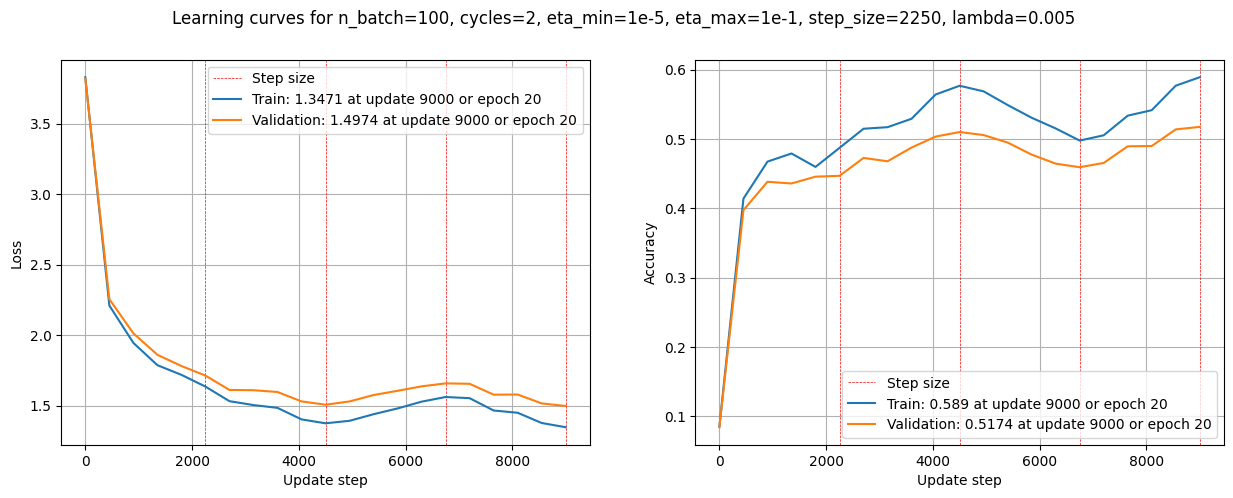

In [29]:
# Plot the learning curve
title = 'for n_batch=100, cycles=2, eta_min=1e-5, eta_max=1e-1, step_size=2250, lambda=0.005'
plot_learning_curve(metrics, title=title, step_size=GDparams['step_size'], cycles=GDparams['cycles'])
plt.savefig('Figures/'+str(figure)+'_2_1_Curves.png', bbox_inches="tight"); figure+=1

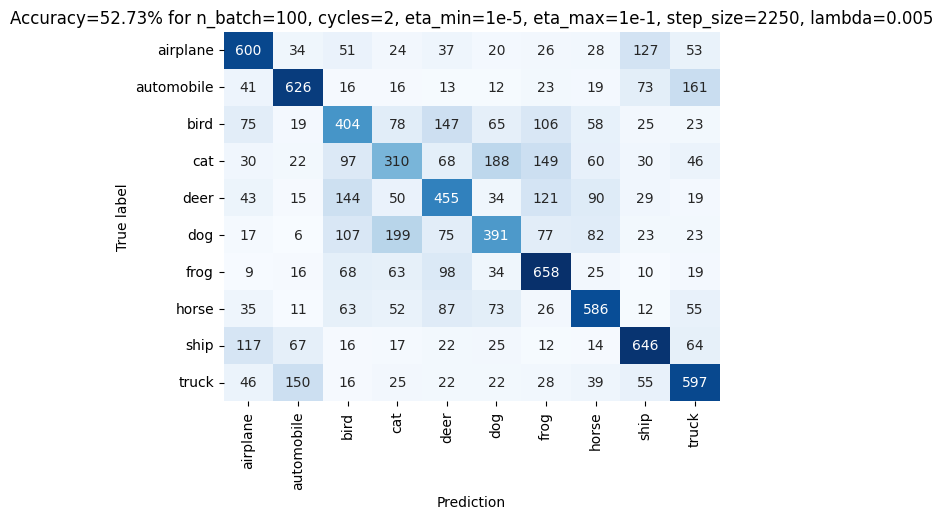

In [30]:
confusion_matrix(images_test, labels_test, W, b, use_batchnorm=False, title=title)
plt.savefig('Figures/'+str(figure)+'_2_1_Confusion.png', bbox_inches="tight"); figure+=1

# Training a 3 layer network

50 nodes in the first hidden layer

50 nodes in the second hidden layer


In [38]:
hidden_dimensions = [50,50]

# Initialize weitghs
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True)

# Train the network
W, b, metrics = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, 
                X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val, use_batchnorm=False)

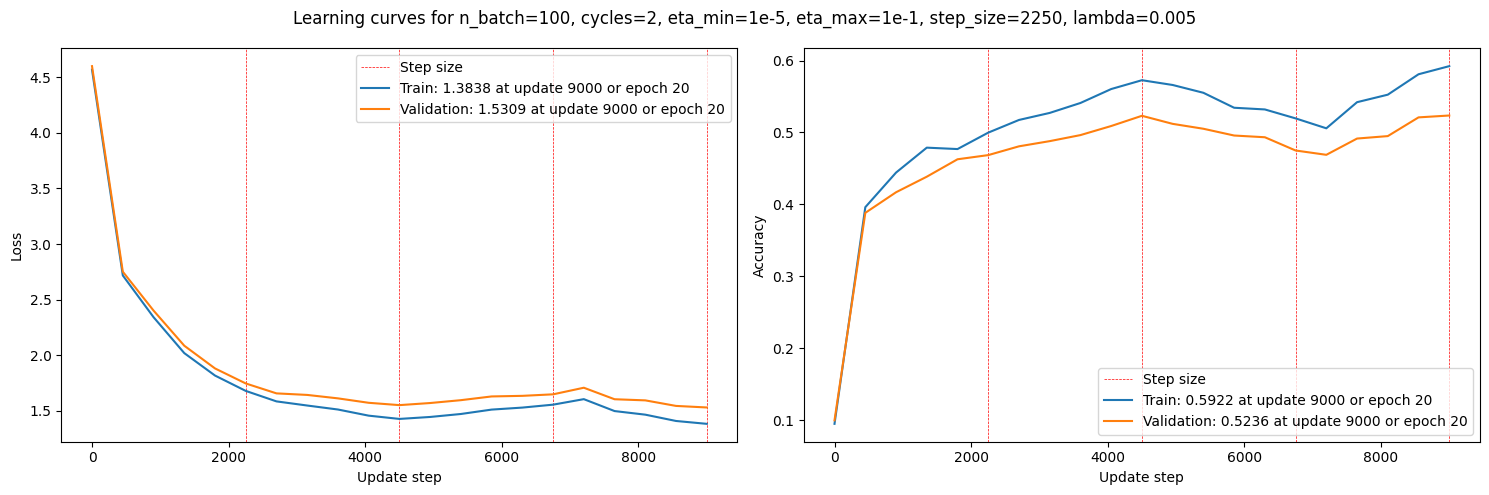

In [39]:
# Plot the learning curve
title = 'for n_batch=100, cycles=2, eta_min=1e-5, eta_max=1e-1, step_size=2250, lambda=0.005'
plot_learning_curve(metrics, title=title, step_size=GDparams['step_size'], cycles=GDparams['cycles'])
plt.savefig('Figures/'+str(figure)+'_2_2_Curves.png', bbox_inches="tight"); figure+=1

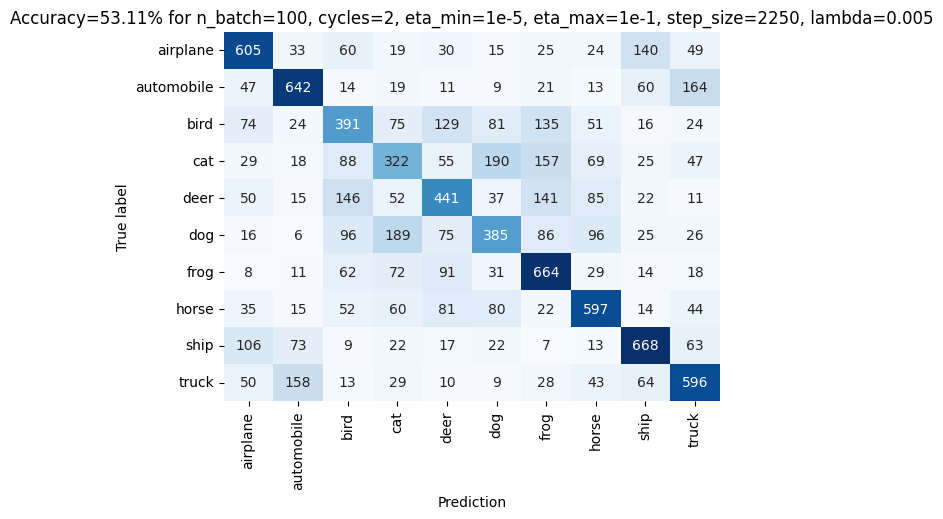

In [40]:
confusion_matrix(images_test, labels_test, W, b, use_batchnorm=False, title=title)
plt.savefig('Figures/'+str(figure)+'_2_2_Confusion.png', bbox_inches="tight"); figure+=1

### Training a 9 layer network

whose number of nodes at the hidden layers are ```[50, 30, 20, 20, 10, 10, 10, 10]```

In [41]:
hidden_dimensions = [50,30,20,20,10,10,10,10]

# Initialize weitghs
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True)

# Train the network
W, b, metrics = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, 
                X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val, use_batchnorm=False)

The accuracy of the network went down significantly as the complexity increases.

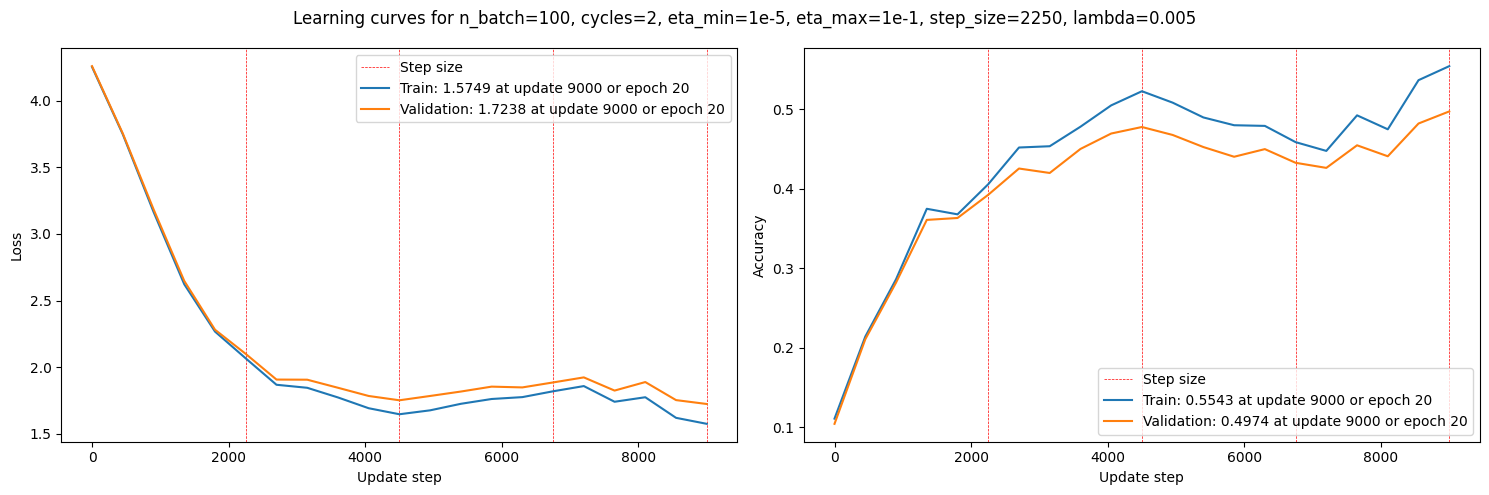

In [42]:
# Plot the learning curve
title = 'for n_batch=100, cycles=2, eta_min=1e-5, eta_max=1e-1, step_size=2250, lambda=0.005'
plot_learning_curve(metrics, title=title, step_size=GDparams['step_size'], cycles=GDparams['cycles'])
plt.savefig('Figures/'+str(figure)+'_2_3_Curves.png', bbox_inches="tight"); figure+=1

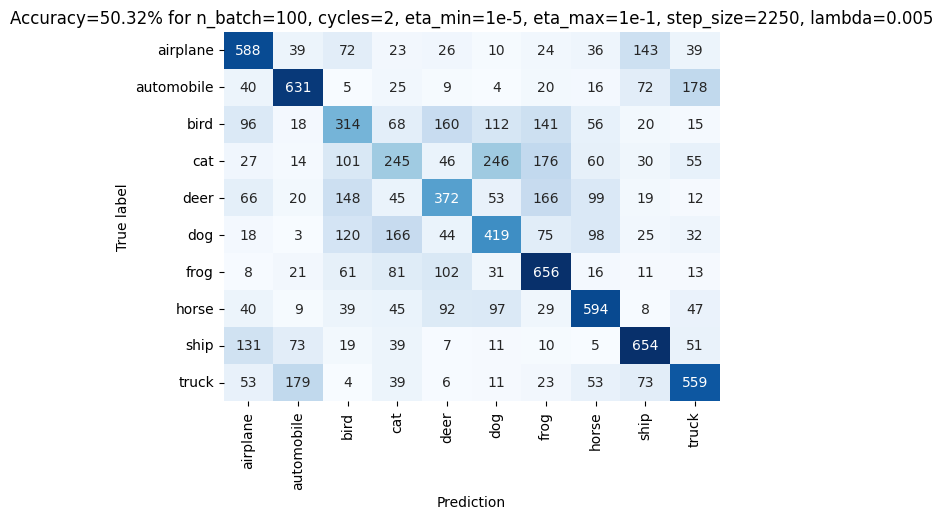

In [43]:
confusion_matrix(images_test, labels_test, W, b, use_batchnorm=False, title=title)
plt.savefig('Figures/'+str(figure)+'_2_3_Confusion.png', bbox_inches="tight"); figure+=1

## Implement batch normalization

In [65]:
# we use only the first 10 dimensions of the data, as well as only the first 5 images in the training data.
# also, no regularization is used

X = images_train[0:10,0:5]
Y = labels_one_hot_train[:,0:5]
lambda_ = 0

### 2-layer network

with 50 hidden nodes

In [60]:
import numpy as np

def compare_gradients(analytic_grads, numeric_grads, param_names):
    num_layers = len(analytic_grads[0])
    
    for layer in range(num_layers):
        print(f"Layer {layer}:")
        for param_name, analytic, numeric in zip(param_names, analytic_grads, numeric_grads):
            if layer < len(analytic):
                a, n = analytic[layer], numeric[layer]
                abs_diff = np.abs(a - n)
                percent_small_errors = np.mean(abs_diff < 1e-6) * 100
                max_error = np.max(abs_diff)
                print(f" {param_name.capitalize()}")
                print(f"  % of absolute errors below 1e-6: {percent_small_errors:.2f}%")
                print(f"  Maximum absolute error: {max_error:.2e}")
        print("_" * 44)


# Initialize weights (assuming this part remains unchanged)
input_dimension = X.shape[0]
hidden_dimensions = [50]
output_dimension = Y.shape[0]
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension)

# Compute the gradients numerically
grad_W_num, grad_b_num, grad_gamma_num, grad_beta_num = ComputeGradsNum(
    X, Y, lambda_, W, b, gamma, beta, mean=None, var=None, use_batchnorm=True
)

# Compute the gradients analytically
P, S_BN, S, X_layers, mean_avg, var_avg = EvaluateClassifier(
    X, W, b, gamma, beta, mean=None, var=None, use_batchnorm=True
)
grad_W, grad_b, grad_gamma, grad_beta = ComputeGradients(
    X=X, Y=Y, P=P, S_BN=S_BN, S=S, X_layers=X_layers, W=W, b=b, gamma=gamma, beta=beta,
    mean=mean_avg, var=var_avg, lambda_=lambda_, use_batchnorm=True
)

# Compare gradients
analytic_grads = [grad_W, grad_b, grad_gamma, grad_beta]
numeric_grads = [grad_W_num, grad_b_num, grad_gamma_num, grad_beta_num]
param_names = ['weights', 'bias', 'gamma', 'beta']

compare_gradients(analytic_grads, numeric_grads, param_names)

Layer 0:
 Weights
  % of absolute errors below 1e-6: 99.40%
  Maximum absolute error: 1.40e-06
 Bias
  % of absolute errors below 1e-6: 100.00%
  Maximum absolute error: 8.88e-10
 Gamma
  % of absolute errors below 1e-6: 100.00%
  Maximum absolute error: 1.91e-08
 Beta
  % of absolute errors below 1e-6: 100.00%
  Maximum absolute error: 2.48e-08
____________________________________________
Layer 1:
 Weights
  % of absolute errors below 1e-6: 100.00%
  Maximum absolute error: 8.29e-08
 Bias
  % of absolute errors below 1e-6: 100.00%
  Maximum absolute error: 7.18e-08
____________________________________________


### 3-layer neural network

with 50,50 nodes in each hidden layer

In [61]:
# Initialize weitghs
hidden_dimensions = [50,50]
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension)

# Compute the gradients numerically
grad_W_num, grad_b_num, grad_gamma_num, grad_beta_num = \
    ComputeGradsNum(X, Y, lambda_, W, b, gamma, beta, mean=None, var=None, use_batchnorm=True)

# Compute the gradients analytically
P, S_BN, S, X_layers, mean_avg, var_avg = \
    EvaluateClassifier(X, W, b, gamma, beta, mean=None, var=None, use_batchnorm=True)
grad_W, grad_b, grad_gamma, grad_beta = \
    ComputeGradients(X=X, Y=Y, P=P, S_BN=S_BN, S=S, X_layers=X_layers, W=W, b=b, gamma=gamma, beta=beta,
                     mean=mean_avg, var=var_avg, lambda_=lambda_, use_batchnorm=True)

# Compare gradients
analytic_grads = [grad_W, grad_b, grad_gamma, grad_beta]
numeric_grads = [grad_W_num, grad_b_num, grad_gamma_num, grad_beta_num]
param_names = ['weights', 'bias', 'gamma', 'beta']

compare_gradients(analytic_grads, numeric_grads, param_names)

Layer 0:
 Weights
  % of absolute errors below 1e-6: 99.60%
  Maximum absolute error: 1.14e-06
 Bias
  % of absolute errors below 1e-6: 100.00%
  Maximum absolute error: 4.44e-10
 Gamma
  % of absolute errors below 1e-6: 100.00%
  Maximum absolute error: 4.48e-08
 Beta
  % of absolute errors below 1e-6: 100.00%
  Maximum absolute error: 6.08e-08
____________________________________________
Layer 1:
 Weights
  % of absolute errors below 1e-6: 100.00%
  Maximum absolute error: 2.52e-07
 Bias
  % of absolute errors below 1e-6: 100.00%
  Maximum absolute error: 3.89e-17
 Gamma
  % of absolute errors below 1e-6: 100.00%
  Maximum absolute error: 2.67e-08
 Beta
  % of absolute errors below 1e-6: 100.00%
  Maximum absolute error: 2.92e-08
____________________________________________
Layer 2:
 Weights
  % of absolute errors below 1e-6: 100.00%
  Maximum absolute error: 8.74e-08
 Bias
  % of absolute errors below 1e-6: 100.00%
  Maximum absolute error: 6.77e-08
_________________________________

## Training a 3-layer neural network

### with Batch Normalization

In [83]:
input_dimension = images_train.shape[0]
hidden_dimensions = [50,50]
output_dimension = labels_one_hot_train.shape[0]

# Initialize weitghs
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True)

# Define the network parameters
lambda_ = 0.005
GDparams = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

# Train the network
W, b, gamma, beta, mean_avg, var_avg, metrics = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, gamma, beta, 
                images_val, labels_one_hot_val, labels_val, use_batchnorm=True)

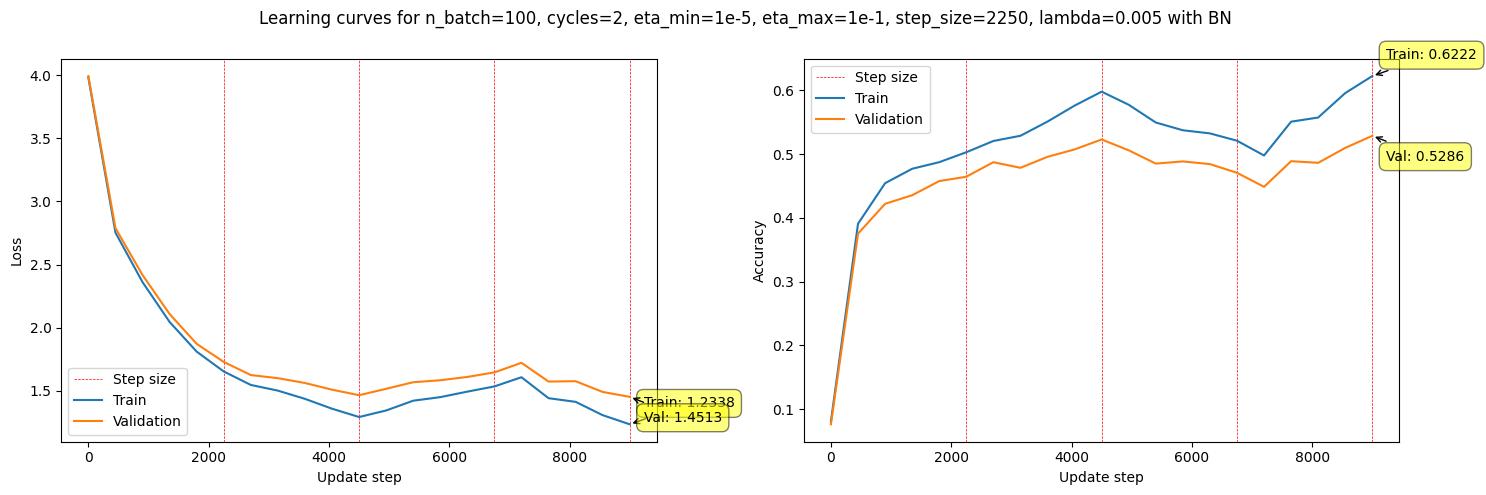

In [84]:
# Plot the learning curve
title = 'for n_batch=100, cycles=2, eta_min=1e-5, eta_max=1e-1, step_size=2250, lambda=0.005 with BN'
plot_learning_curve(metrics, title=title, step_size=GDparams['step_size'], cycles=GDparams['cycles'])
plt.savefig('Figures/'+str(figure)+'_3_2_Curves_BN.png', bbox_inches="tight"); figure+=1

### Without Batch Normalization

In [85]:
input_dimension = images_train.shape[0]
hidden_dimensions = [50,50]
output_dimension = labels_one_hot_train.shape[0]

# Initialize weitghs
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True)

# Define the network parameters
lambda_ = 0.005
GDparams = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

# Train the network
W, b, metrics = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, gamma, beta, 
                images_val, labels_one_hot_val, labels_val, use_batchnorm=False)

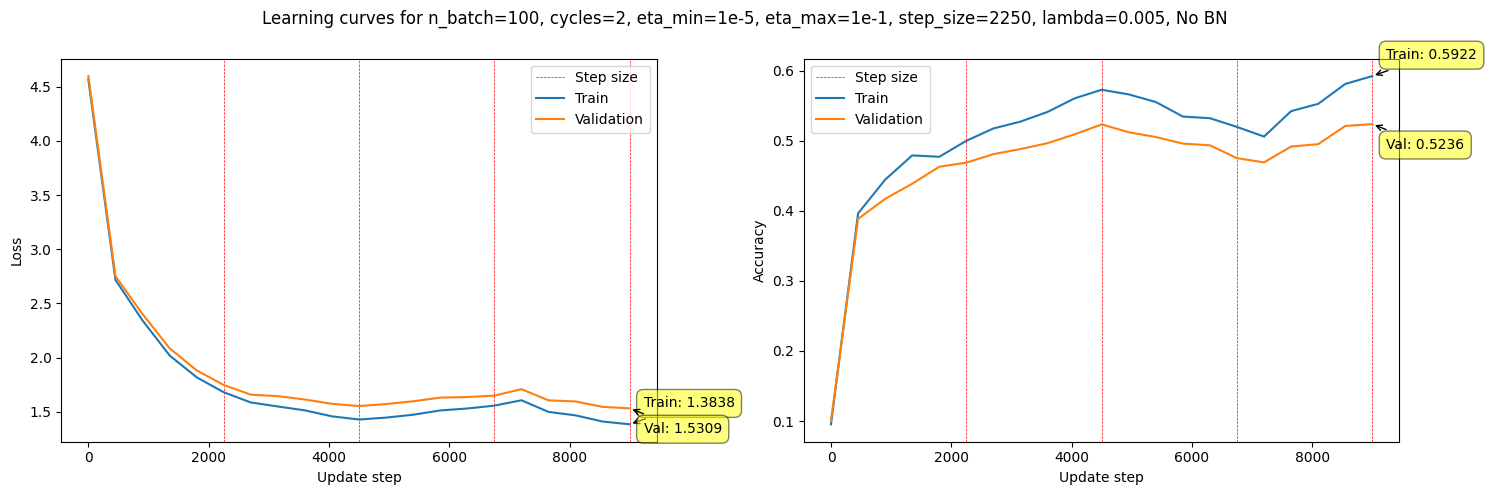

In [86]:
# Plot the learning curve
title = 'for n_batch=100, cycles=2, eta_min=1e-5, eta_max=1e-1, step_size=2250, lambda=0.005, No BN'
plot_learning_curve(metrics, title=title, step_size=GDparams['step_size'], cycles=GDparams['cycles'])
plt.savefig('Figures/'+str(figure)+'_3_3_Curves_No_BN.png', bbox_inches="tight"); figure+=1

## Training a 9-layer neural network

hidden_dimensions = [50,30,20,20,10,10,10,10]

### Without batch normalization

In [88]:
49.8

# Initialize weitghs
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True)

# Train the network
W, b, metrics = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, 
                X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val, use_batchnorm=False)

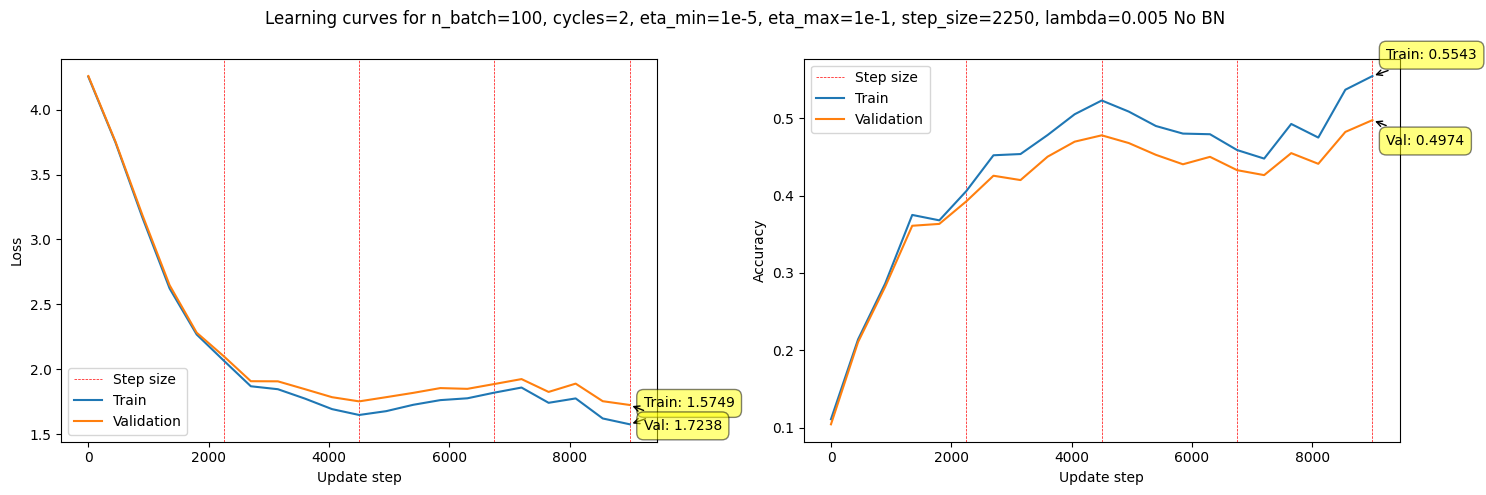

In [89]:
# Plot the learning curve
title = 'for n_batch=100, cycles=2, eta_min=1e-5, eta_max=1e-1, step_size=2250, lambda=0.005 No BN'
plot_learning_curve(metrics, title=title, step_size=GDparams['step_size'], cycles=GDparams['cycles'])
plt.savefig('Figures/'+str(figure)+'_2_3_Curves.png', bbox_inches="tight"); figure+=1

In [91]:
# Initialize weitghs
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True)

# Train the network
W, b, gamma, beta, mean_avg, var_avg, metrics= \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, gamma=gamma, beta=beta,
                X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val, use_batchnorm=True)

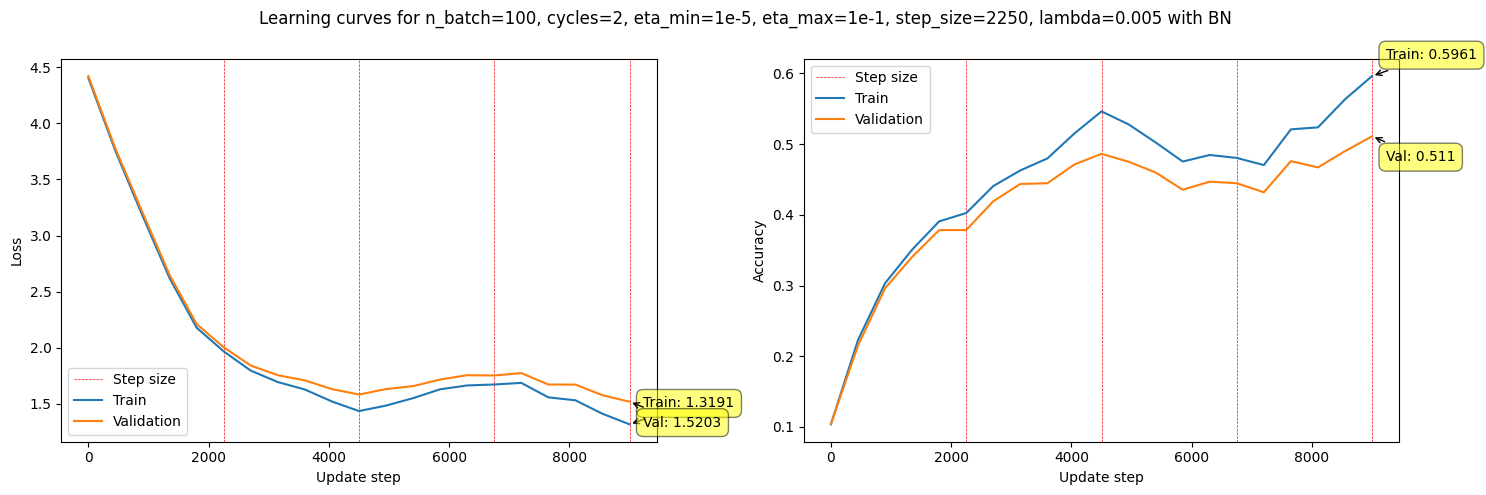

In [92]:
# Plot the learning curve
title = 'for n_batch=100, cycles=2, eta_min=1e-5, eta_max=1e-1, step_size=2250, lambda=0.005 with BN'
plot_learning_curve(metrics, title=title, step_size=GDparams['step_size'], cycles=GDparams['cycles'])
plt.savefig('Figures/'+str(figure)+'_2_3_Curves.png', bbox_inches="tight"); figure+=1

## Search for best Lambda

In [93]:
def grid_search(list_lambdas, X, Y, y, GDparams, W, b, gamma, beta, use_batchnorm, X_val=None, 
                Y_val=None, y_val=None, plot=True, log_scale=True):
    
    # Create a dictionary to store the performance metrics (mean/std by lambda)
    metrics_lambdas = {'lambdas':list_lambdas, 'loss_train':[], 'acc_train':[]}
    if X_val is not None:
        metrics_lambdas['loss_val'] = []
        metrics_lambdas['acc_val'] = []
        
    # Iterate the lambda values
    for lambda_ in list_lambdas:
        
        if use_batchnorm:
            W_, b_, gamma_, beta_, mean_avg, var_avg, metrics = \
                MiniBatchGD(X, Y, y, GDparams, lambda_, W, b, gamma, beta, X_val, Y_val, y_val, 
                            use_batchnorm)
        else:
            W_, b_, metrics = \
                MiniBatchGD(X, Y, y, GDparams, lambda_, W, b, gamma, beta, X_val, Y_val, y_val, 
                            use_batchnorm) 
        
        # Save the performance metrics of the lambda for this random initalization
        metrics_lambdas['loss_train'].append(metrics['loss_train'][-1])
        metrics_lambdas['acc_train'].append(metrics['acc_train'][-1])
        if X_val is not None:
            metrics_lambdas['loss_val'].append(metrics['loss_val'][-1])
            metrics_lambdas['acc_val'].append(metrics['acc_val'][-1])
                
    if plot:
        _, axes = plt.subplots(1, 2, figsize=(15,5))
        title = 'for n_batch='+str(GDparams['n_batch'])+', cycles='+str(GDparams['cycles'])+ \
                ', eta_min='+str(GDparams['eta_min'])+', eta_max='+str(GDparams['eta_max'])+ \
                ', step_size='+str(GDparams['step_size'])
        plt.suptitle('Learning curves '+title)

        # Iterate the performance metrics
        for metric, ax in zip(['loss', 'acc'], axes.flatten()):

            # Find the optimal metric value and the corresponding lambda for training set
            optimal_lambda_train = np.argmin(metrics_lambdas[metric+'_train']) if metric=='loss' \
                                   else np.argmax(metrics_lambdas[metric+'_train'])
            optimal_train = np.round(metrics_lambdas[metric+'_train'][optimal_lambda_train], 4)
            
            # Plot the learning curve of training set
            x = np.log(metrics_lambdas['lambdas']) if log_scale else metrics_lambdas['lambdas']
            y = metrics_lambdas[metric+'_train']
            label = 'Train: '+str(optimal_train)+ ' at $\lambda$ '+ \
                    str(metrics_lambdas['lambdas'][optimal_lambda_train])
            ax.plot(x, y, 'o', label=label)
            
            # If validation set...
            if len(metrics_lambdas)>3:

                # Find the optimal metric value and the corresponding lambda for training set
                optimal_lambda_val = np.argmin(metrics_lambdas[metric+'_val']) if metric=='loss' \
                                     else np.argmax(metrics_lambdas[metric+'_val'])
                optimal_val = np.round(metrics_lambdas[metric+'_val'][optimal_lambda_val], 4)
            
                # Plot the learning curve of validation set
                x = np.log(metrics_lambdas['lambdas']) if log_scale else metrics_lambdas['lambdas']
                y = metrics_lambdas[metric+'_val']
                label = 'Validation: '+str(optimal_val)+ ' at $\lambda$ '+ \
                        str(metrics_lambdas['lambdas'][optimal_lambda_val])
                ax.plot(x, y, 'o', label=label)

            # Add axis, legend and grid
            ax.set_xlabel("Log Lambdas" if log_scale else "Lambdas")
            ax.set_ylabel('Accuracy' if metric=='acc' else 'Loss')
            ax.legend()
            ax.grid(True)

    return metrics_lambdas

In [97]:
np.random.seed(10)
l_max, l_min = -1, -5
l = l_min+(l_max-l_min)*np.random.rand(10)
list_lambdas_coarse = list(10**l)
list_lambdas_coarse.sort()
# Print each value with a fixed-point format
formatted_list = [format(value, '.8f') for value in list_lambdas_coarse]
print(formatted_list)

['0.00001211', '0.00002256', '0.00004747', '0.00006198', '0.00007928', '0.00098634', '0.00342447', '0.00989044', '0.01101851', '0.01216978']


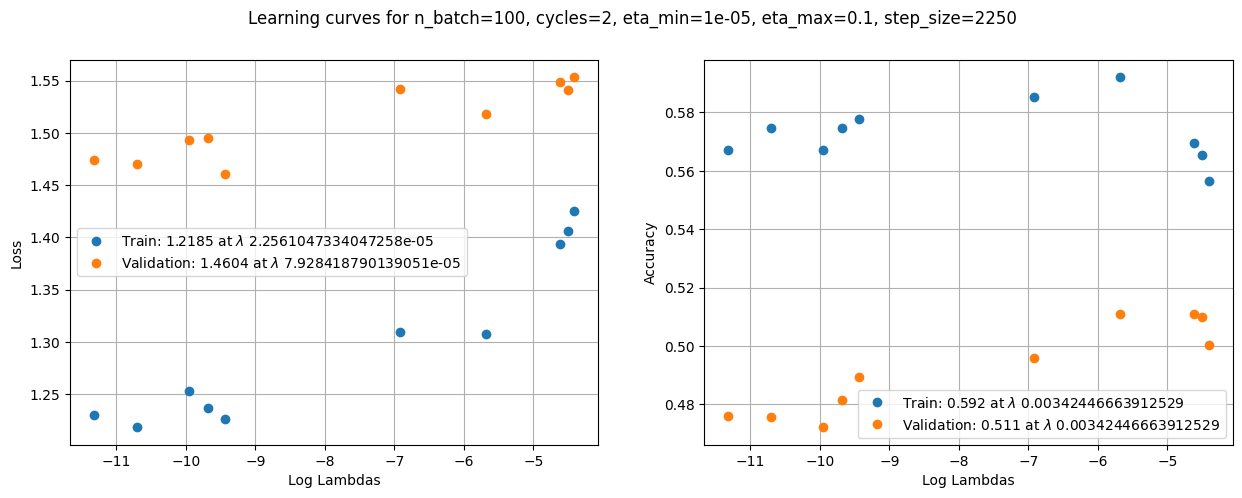

In [100]:
# Initialize weitghs
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True)

# Run the search for lambda
metrics_by_lambdas_coarse = \
    grid_search(list_lambdas_coarse, images_train, labels_one_hot_train, labels_train, GDparams, W, b, 
                gamma, beta, use_batchnorm=True, X_val=images_val, Y_val=labels_one_hot_val, 
                y_val=labels_val, plot=True, log_scale=True)

plt.savefig('Figures/'+str(figure)+'_3_3_Coarse.png', bbox_inches="tight"); figure+=1

In [101]:
metrics_by_lambdas_coarse

{'lambdas': [1.2106198691436026e-05,
  2.2561047334047258e-05,
  4.747263588107293e-05,
  6.197998389259432e-05,
  7.928418790139051e-05,
  0.0009863431872330058,
  0.00342446663912529,
  0.009890438121030054,
  0.01101850945826356,
  0.012169775677700535],
 'loss_train': [1.2297799305208965,
  1.2184587179122635,
  1.2530501167127719,
  1.2372036986635897,
  1.2263769400873472,
  1.3090771531532692,
  1.3076899774554585,
  1.3937669853375168,
  1.4061177664404736,
  1.4251900592665965],
 'acc_train': [0.5670666666666667,
  0.5745333333333333,
  0.5672666666666667,
  0.5747555555555556,
  0.5777333333333333,
  0.5851777777777778,
  0.5920444444444445,
  0.5693777777777778,
  0.5653111111111111,
  0.5564666666666667],
 'loss_val': [1.4736868553070137,
  1.4699620118354946,
  1.492769910067867,
  1.4952164998723567,
  1.460430071558763,
  1.542051479033972,
  1.518160282832719,
  1.5489413009815467,
  1.5409303083850863,
  1.5531713334537025],
 'acc_val': [0.4762,
  0.4756,
  0.4722,
  0

## Batch Normalization and sensitivity to initialization

In [102]:
hidden_dimensions = [50,50]

# Define the network parameters
lambda_ = 0.005
GDparams = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

results = np.array(["Sigma","Batch Normalization","Test Accuracy"])

for sigma in [1e-1,1e-3,1e-4]:
    
    # Initialize weitghs
    W, b, gamma, beta = \
        initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=False, std=sigma)

    for use_batchnorm in [False,True]:
        
        # Train the network
        if use_batchnorm:
            W_, b_, gamma_, beta_, mean_avg, var_avg, metrics = \
                MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, 
                            gamma, beta, images_val, labels_one_hot_val, labels_val, 
                            use_batchnorm=True)
        else:
            W_, b_, metrics = \
                MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, 
                            X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val,
                            use_batchnorm=False)
            gamma_, beta_, mean_avg, var_avg = None, None, None, None
            
        # Save test accuracy
        accuracy_test = ComputeAccuracy(images_test, labels_test, W_, b_, gamma_, beta_, mean_avg, 
                                        var_avg, use_batchnorm)
        results = np.vstack((results,[sigma,use_batchnorm,accuracy_test]))


In [103]:
results

array([['Sigma', 'Batch Normalization', 'Test Accuracy'],
       ['0.1', '0.0', '0.5296'],
       ['0.1', '1.0', '0.5378'],
       ['0.001', '0.0', '0.1'],
       ['0.001', '1.0', '0.536'],
       ['0.0001', '0.0', '0.1'],
       ['0.0001', '1.0', '0.536']], dtype='<U32')